### Классификация текста

Одной из широко используемых задач NLP в различных бизнес-задачах является “классификация текста”. Цель классификации текста состоит в том, чтобы автоматически классифицировать текстовые документы по одной или нескольким определенным категориям. Некоторые примеры классификации текста:
- Определенеие настроений аудитории из социальных сетей
- Обнаружение спама и нежелательных писем
- Автоматическая маркировка запросов клиентов
- Категоризация новостных статей по определенным темам

Классификация текста является примером задачи машинного обучения с учителем, поскольку для обучения классификатора используется помеченный набор данных, содержащий текстовые документы и их метки. Пайплайн классификации текста состоит из 4 основных частей:
1. Подготовка данных
2. Генерация признаков
3. Тренировка модели
4. Оценка и тьюнинг модели

Проделаем данные шаги.

In [1]:
%pip install -U scikit-learn
# %pip install pandas
# %pip install sklearn

# %pip install xlrd
# %pip install pymorphy2
# %pip install stop_words
# conda install -c conda-forge stop-words

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
data = pd.read_excel("отзывы_за_лето.xls")

In [11]:
data

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01
20655,5,Ок,2017-06-01
20656,4,Доволен,2017-06-01
20657,1,"Песопаснасть, рут ни нужын",2017-06-01


#### Предобработка текста

Сделаем некоторую базовую предобработку текста

In [6]:
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation

exclude = set(punctuation)
sw = set(get_stop_words("ru"))
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    # if txt.find("не ")!=-1:
        # print(txt)
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in exclude]
    return " ".join(txt)

data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3]
data['target'] = data['Rating'] > 3

In [4]:
data

,Rating,Content,Date,text,target
0,5,It just works!,2017-08-14,it just works,True
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,в целое удобноной приложениеиз минус хотеть сл...,True
2,5,Отлично все,2017-08-14,отлично всё,True
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стать зависать на 1 работа антивирус далёкий н...,True
4,5,"Очень удобно, работает быстро.",2017-08-14,очень удобно работать быстро,True
...,...,...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01,ну и шляпас роот право бесполезный прогаразраб...,False
20655,5,Ок,2017-06-01,около,True
20656,4,Доволен,2017-06-01,довольный,True
20657,1,"Песопаснасть, рут ни нужын",2017-06-01,песопаснастя рута ни нужын,False


In [7]:
from sklearn import model_selection, preprocessing
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(data['text'], data['target'])

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [6]:
train_y

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [27]:
train_x.values

array(['всё супер стать мнеудобный', '👍👍👍', 'мненравиться', ...,
       'отлично', 'здоровье вы', 'удобно'], dtype=object)

In [8]:
count_vect = CountVectorizer().fit(train_x.values)

xtrain_count = count_vect.transform(train_x)
xvalid_count = count_vect.transform(valid_x)

tfidf_vec = TfidfVectorizer().fit(train_x.values)
xtrain_tfidf = tfidf_vec.transform(train_x)
xvalid_tfidf = tfidf_vec.transform(valid_x)

tfidf_vec_ngrams = TfidfVectorizer(ngram_range=(1, 3)).fit(train_x.values)
xtrain_tfidf_ngram = tfidf_vec.transform(train_x)
xvalid_tfidf_ngram = tfidf_vec.transform(valid_x)



In [28]:
xtrain_count

<14811x9523 sparse matrix of type '<class 'numpy.int64'>'
	with 94660 stored elements in Compressed Sparse Row format>

#### Построение моделей

Последний шаг в процессе классификации текста - это обучение классификатора с использованием признаков, созданных на предыдущем шаге. Опробуем несколько вариантов моделей машинного обучения.

In [9]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

##### Naive Bayes

Наивный Байес - это метод классификации, основанный на теореме Байеса с допущением независимости между предикторами. Наивный байесовский классификатор предполагает, что наличие определенного признака в классе не связано с наличием какого-либо другого признака в нем.

In [10]:
from sklearn import naive_bayes, linear_model, ensemble, metrics, svm

In [7]:
# Naive Bayes на Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes на Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes на Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

NB, Count Vectors:  0.9311322665586389
NB, WordLevel TF-IDF:  0.918371480656269
NB, N-Gram Vectors:  0.918371480656269


 ##### Linear Classifier (Логистическая регрессия)
 
Логистическая регрессия измеряет связь между категориальной зависимой переменной и одной или несколькими независимыми переменными путем оценки вероятностей, используя логистическую/сигмоидную функцию. 

In [8]:
# Linear Classifier на Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier на Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier на Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy)

LR, Count Vectors:  0.9230301802714199
LR, WordLevel TF-IDF:  0.926068462629127
LR, N-Gram Vectors:  0.926068462629127


##### SVM

SVM -  алгоритм машинного обучения с учителем, который может быть использован как для классификации, так и для регрессии. Модель извлекает наилучшую возможную гиперплоскость/линию, которая разделяет эти два класса.

In [29]:
accuracy = train_model(svm.SVC(), xtrain_count, train_y, xvalid_count)
print("SVM, Count Vectors: ", accuracy)

SVM, Count Vectors:  0.9254608061575855


In [9]:
# SVM на Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVM, N-Gram Vectors: ", accuracy)


SVM, N-Gram Vectors:  0.9311322665586389


##### RandomForest

Cлучайный лес - ансамбль решающих деревьев.

In [ ]:
# %pip install tqdm
# %pip install matplotlib

In [24]:
# from tqdm import tqdm_notebook
from tqdm.notebook import tqdm as tqdm_notebook

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

[]

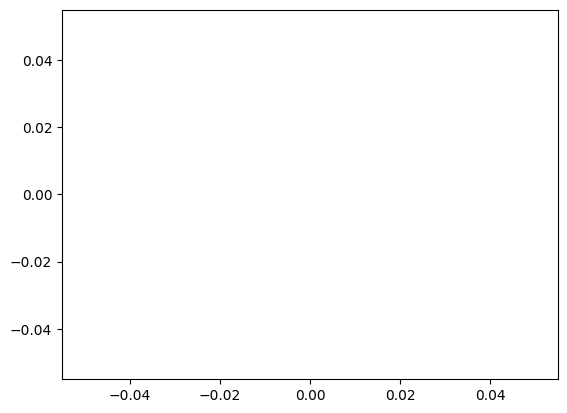

In [18]:
plt.plot()

In [ ]:
# %pip install ipywidgets

In [23]:
clf = ensemble.RandomForestClassifier(n_estimators=10).fit(xtrain_count, train_y)

In [25]:
%%time
acs = []
for i in tqdm_notebook([10, 30, 60, 100, 1000, 2000]):
    print(i)
    clf = ensemble.RandomForestClassifier(n_estimators=i).fit(xtrain_count, train_y)
    acs.append(metrics.accuracy_score(clf.predict(xvalid_count), valid_y))
    print('done')
    

  0%|          | 0/6 [00:00<?, ?it/s]

10
done
30
done
60
done
100
done
1000
done
2000
done
CPU times: total: 39min 35s
Wall time: 1h 4min 1s


In [26]:
acs

[0.9104719465262305,
 0.9163459590844643,
 0.9175612720275471,
 0.9208021065424347,
 0.9214097630139761,
 0.9203970022280737]

In [30]:
%%timeit
# RF на Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_jobs=-1,verbose=1), xtrain_count, train_y, xvalid_count)
print("RF, Count Vectors: ", accuracy)

# RF на Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_jobs=-1,verbose=2), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished


RF, Count Vectors:  0.9201944500708933
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.1s


building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, WordLevel TF-IDF:  0.9218148673283371


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, Count Vectors:  0.9224225237998784
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.9s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.1s finished


RF, WordLevel TF-IDF:  0.9228276281142395


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, Count Vectors:  0.91877658497063
building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   49.0s


building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, WordLevel TF-IDF:  0.9205995543852542


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, Count Vectors:  0.9208021065424347
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.7s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, WordLevel TF-IDF:  0.9228276281142395


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, Count Vectors:  0.9197893457565323
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.4s


building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, WordLevel TF-IDF:  0.9208021065424347


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, Count Vectors:  0.9212072108567956
building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.6s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, WordLevel TF-IDF:  0.922219971642698


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, Count Vectors:  0.9175612720275471
building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100building tree 16 of 100

building tree 17 of 100building tree 18 of 100

building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.3s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, WordLevel TF-IDF:  0.922219971642698


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


RF, Count Vectors:  0.9191816892849909
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.5s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.2s


RF, WordLevel TF-IDF:  0.9208021065424347
2min 28s ± 24.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished


##### Boosting Model

Бустинг - процедура последовательного построения композиции алгоритмов машинного обучения, когда каждый следующий алгоритм стремится компенсировать недостатки композиции всех предыдущих алгоритмов.

In [4]:
import os


In [5]:
os.environ['KMP_DUPLICATE_LIB_OK']='true'

In [3]:
# %pip install scipy
%pip install --upgrade pip

     ---------------------------------------- 2.0/2.0 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Note: you may need to restart the kernel to use updated packages.


In [1]:
# %pip install xgboost
%pip show xgboost


Name: xgboost
Version: 1.6.2
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: 
Author-email: 
License: Apache-2.0
Location: c:\users\user\skillfactory\github\module_14\t14_39\lib\site-packages
Requires: numpy, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [11]:
import xgboost as xgb

In [8]:
xtrain_count.tocsc()

<14811x9641 sparse matrix of type '<class 'numpy.int64'>'
	with 95239 stored elements in Compressed Sparse Column format>

In [ ]:
# Extereme Gradient Boosting на Count Vectors
accuracy = train_model(xgb.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)


: 

: 

In [ ]:

# Extereme Gradient Boosting на Word Level TF IDF Vectors
accuracy = train_model(xgb.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", accuracy)

In [ ]:
# conda install -c conda-forge stop-words не заработал ни под каким соусом. ни в каком питоне, ни в конде, ни отдельно